<a href="https://colab.research.google.com/github/DiazOnFire/FoodVision_V1/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Done with the help of tutorials I found online to learn about Google Vision Transformers and HuggingFace.

In [ ]:
pip install transformers pytorch-lightning --quiet


In [ ]:
! sudo apt -qq install git-lfs
! git config --global credential.helper store

git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
#importing necessary libraries
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

Please specify the number of classes you want to define and provide the search terms for each class. If you have less than five classes, you can leave the remaining text boxes blank.

In [ ]:
term_1 = "pizza" #@param {type:"string"}
term_2 = "burger" #@param {type:"string"}
term_3 = "pasta" #@param {type:"string"}
term_4 = "sandwich" #@param {type:"string"}
term_5 = "doughnuts" #@param {type:"string"}

search_terms = sorted([
    term_1,
    term_2,
    term_3,
    term_4,
    term_5
])

search_terms = [x for x in search_terms if x.strip() != '']

# Getting Images from the internet
So, around 200 images are collected of each item typed above from the web and all of it is stored into a folder named **images/** which is suitable for torchvision.datasets.ImageFolder

In [ ]:
#It hits this url and images are downloaded, I had found this in a tutorial online
SEARCH_URL = "https://huggingface.co/api/experimental/images/search"

def get_image_urls_by_term(search_term: str, count=150):
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    response_data = response.json()
    image_urls = [img['thumbnailUrl'] for img in response_data['value']]
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
    for i, image in enumerate(gen_images_from_urls(urls)):
        image.save(save_directory / f'{i}.jpg')

In [ ]:
#This will save the images to the folder Images.
data_dir = Path('images')

if data_dir.exists():
    shutil.rmtree(data_dir)

for search_term in search_terms:
    search_term_dir = data_dir / search_term
    search_term_dir.mkdir(exist_ok=True, parents=True)
    urls = get_image_urls_by_term(search_term)
    print(f"Saving images of {search_term} to {str(search_term_dir)}...")
    urls_to_image_folder(urls, search_term_dir)

Saving images of burger to images/burger...
Retrieved 149 images. Skipped 0.
Saving images of doughnuts to images/doughnuts...
Retrieved 150 images. Skipped 0.
Saving images of pasta to images/pasta...
Retrieved 150 images. Skipped 0.
Saving images of pizza to images/pizza...
Retrieved 150 images. Skipped 0.
Saving images of sandwich to images/sandwich...
Retrieved 149 images. Skipped 1.


So, images have been downloaded, we can move to making training and validation sets for the model


In [ ]:
ds = ImageFolder(data_dir) #torchvision feature used here
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

# We now show some examples of the images that have been downloaded. Some of them might be mislabelled as the search terms I gave are very primitive.

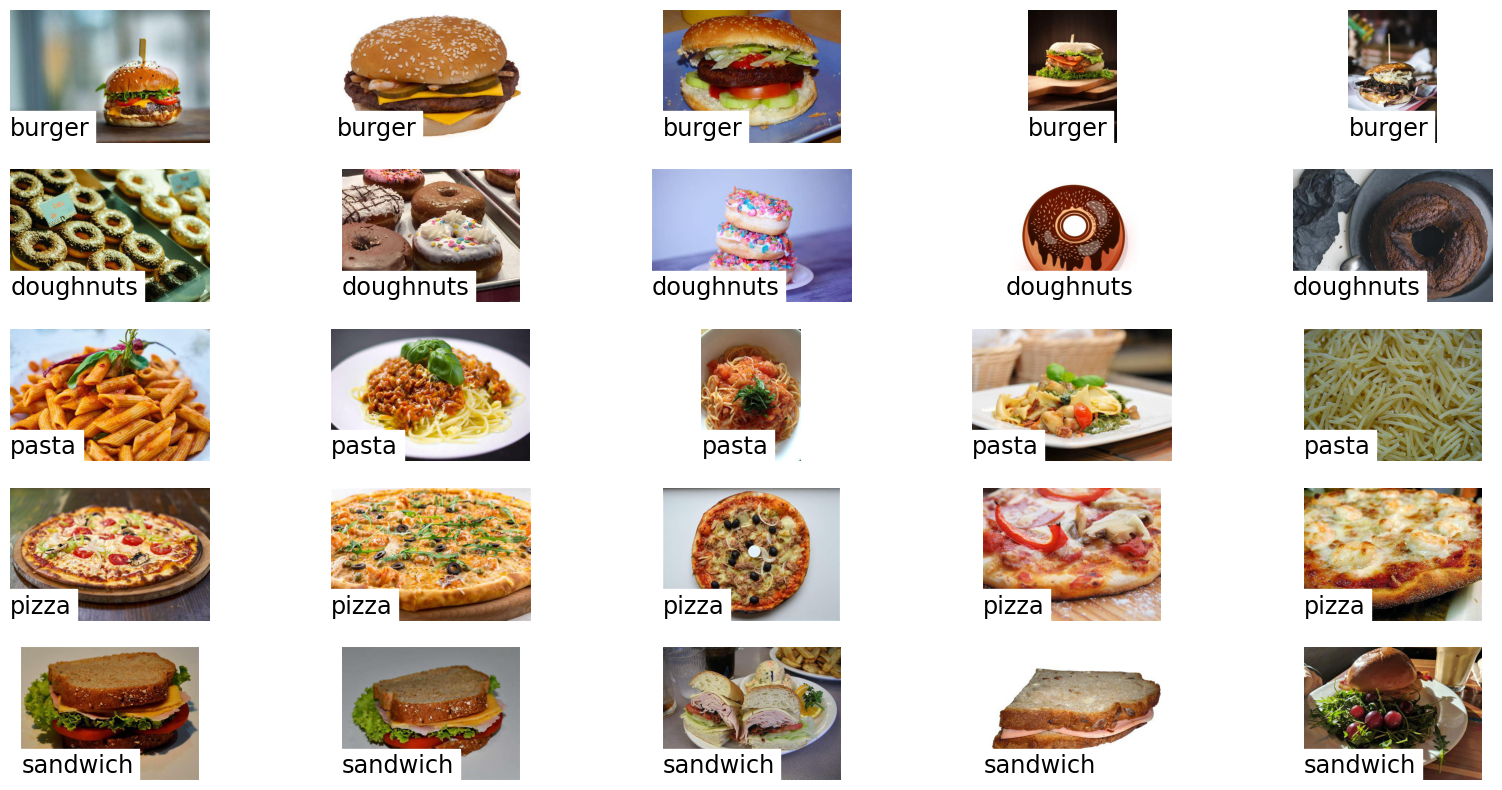

In [ ]:
#To display the images to see what our data looks like
#done using pyplot
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

There is clearly mislabelling but one or two mislabelled items are acceptable.

In [ ]:
#now we add labels so that we get correct labels when we do inference
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [ ]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

# Fine tuning the base model

We are going to download base models which we will fine tune

In [ ]:
#the link from which our pre-trained model is downloaded
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#We use Pytorch Lightning to Fine Tune our model which basically gives you the boilerplate for
#training a model
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=4)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | Multiclass

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Now we check how good/bad fine tuning was

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([4, 0, 0, 0, 0, 1, 1, 2])
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 2])


As we see, it did fairly well, just missing the mark on the first prediction in the above validation set.We can now move on to the next step where we upload this model to huggingface

In [ ]:
notebook_login()

In [ ]:
#This snippet of code is available online to connect colab notebook to HuggingFace
model_id = "FoodVision" #@param {type:"string"}

description = """
"""
task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'
metric_value = trainer.callback_metrics['val_acc'].item()

# Delete model folder, as we (re)create it here.
if Path('./model').exists():
    shutil.rmtree('./model')

token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

hf_username = HfApi().whoami()['name']
model_url = HfApi().create_repo(token=token, repo_id=model_id, exist_ok=True)
model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
model.save_pretrained(model_repo.local_dir)
feature_extractor.save_pretrained(model_repo.local_dir)

# Copy over tensorboard logs from lightning_logs/ into ./model/runs/
tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
model_repo_logs_path.mkdir(exist_ok=True, parents=True)
shutil.copy(tensorboard_logs_path, model_repo_logs_path)

# Copy over a few example images
example_images_dir = Path(model_repo.local_dir) / 'images'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](images/{example_image_path})
'''
example_images_markdown = ""
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    image_path = sorted(folder.glob('*'))[0]
    example_image_path = example_images_dir / f"{class_name.replace(' ', '_')}{image_path.suffix}"
    shutil.copy(image_path, example_image_path)
    example_images_markdown += image_markdown_template.format(
        class_name=class_name,
        example_image_path=example_image_path.name
    )


# Prepare README.md from information gathered above
readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")

Cloning https://huggingface.co/DiazOnFire/FoodVision into local empty directory.
Adding files tracked by Git LFS: ['images/burger.jpg', 'images/doughnuts.jpg', 'images/pasta.jpg', 'images/pizza.jpg', 'images/sandwich.jpg']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file images/pizza.jpg:   0%|          | 1.00/30.3k [00:00<?, ?B/s]

Upload file images/burger.jpg:   0%|          | 1.00/15.8k [00:00<?, ?B/s]

Upload file images/doughnuts.jpg:   0%|          | 1.00/38.7k [00:00<?, ?B/s]

Upload file images/sandwich.jpg:   0%|          | 1.00/26.0k [00:00<?, ?B/s]

Upload file images/pasta.jpg:   0%|          | 1.00/31.1k [00:00<?, ?B/s]

Upload file runs/events.out.tfevents.1689341589.745d32541066.253.0:   0%|          | 1.00/1.46k [00:00<?, ?B/s…

To https://huggingface.co/DiazOnFire/FoodVision
   57f8a9f..b3c2890  main -> main

   57f8a9f..b3c2890  main -> main



Check out your model at:
https://huggingface.co/DiazOnFire/FoodVision
